In [1]:
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_validate, train_test_split
import pandas as pd
import seaborn as sns

In [2]:
# Load the .mat file
mat_file = scipy.io.loadmat('full_data.mat')

# Access the variables stored in the file
print(mat_file.keys())


dict_keys(['__header__', '__version__', '__globals__', 'aligned_zscores', 'folders', 'mean_normed_ZScores', 'unaligned_dFF', 'unaligned_zscores'])


In [3]:
mat_file['aligned_zscores'].shape

(153, 4)

## Things we want to do
### Cell Clustering
cell by stim condition by trial by time = 153 x ...
### PCA of population activity PC1, PC2, and time
### SVM or linear decoding of population activity
binary vs multiclass 
### How many neurons needed

In [4]:
# Generate labels for the conditions
stim_labels = []
for stim_condition_idx in range(mat_file['aligned_zscores'].shape[1]):
    stim_labels += [stim_condition_idx]*mat_file['aligned_zscores'][0,stim_condition_idx].shape[0]

## Cell Clustering

In [ ]:
# create flattened array for cells (# neurons, trialxtime)
cell_array = np.zeros((mat_file['aligned_zscores'].shape[0], mat_file['aligned_zscores'].shape[1] * 250))
for cell in range(mat_file['aligned_zscores'].shape[0]):
    for stim_condition_idx in range(mat_file['aligned_zscores'].shape[1]):
        cell_array[cell, stim_condition_idx * 250:(stim_condition_idx + 1) * 250] = mat_file['aligned_zscores'][cell, stim_condition_idx].mean(axis=0)

Text(0, 0.5, 'Principal Component 2')

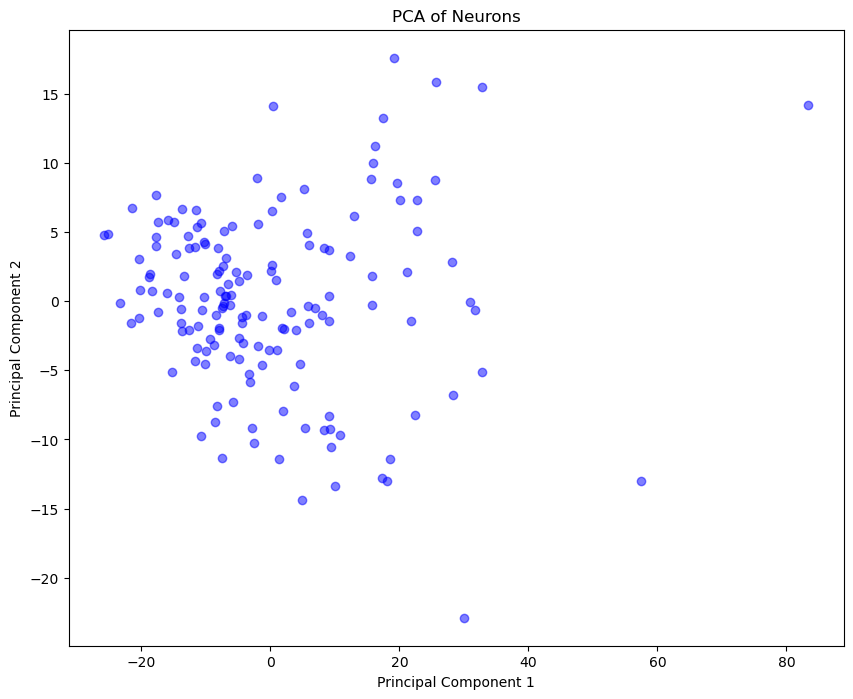

In [34]:
from sklearn.decomposition import PCA
# Perform PCA on the flattened cell array
pca = PCA(n_components=3)
pca_result = pca.fit_transform(cell_array)
# Plot the PCA result
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 8))
plt.scatter(pca_result[:, 0], pca_result[:, 1], c='blue', alpha=0.5)
plt.title('PCA of Neurons')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')


Text(0.5, 1.0, 't-SNE of Neurons')

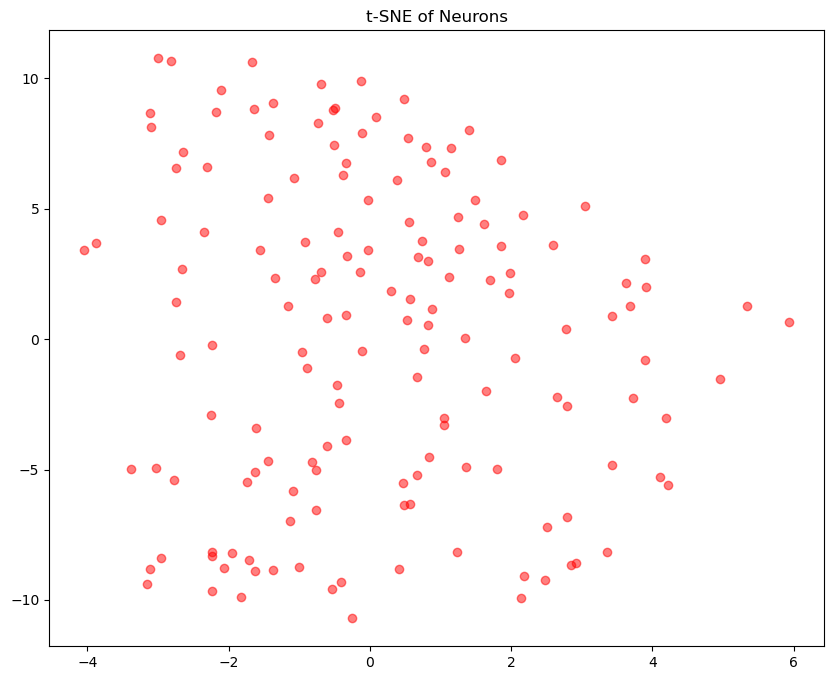

In [35]:
# try tsne
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=42)
tsne_result = tsne.fit_transform(cell_array)
plt.figure(figsize=(10, 8))
plt.scatter(tsne_result[:, 0], tsne_result[:, 1], c='red', alpha=0.5)
plt.title('t-SNE of Neurons')

## Population activity

In [6]:
# make array that is of trial (concat across stim condition), time, cell
trial_array = []
for stim_condition_idx in range(mat_file['aligned_zscores'].shape[1]):
    per_stim_condition_array = np.zeros((mat_file['aligned_zscores'][0, stim_condition_idx].shape[0], 250, mat_file['aligned_zscores'].shape[0]))
    for cell in range(mat_file['aligned_zscores'].shape[0]):
        per_stim_condition_array[:, :, cell] = mat_file['aligned_zscores'][cell, stim_condition_idx]
    trial_array.append(per_stim_condition_array)
trial_array = np.concatenate(trial_array, axis=0)

### PCA

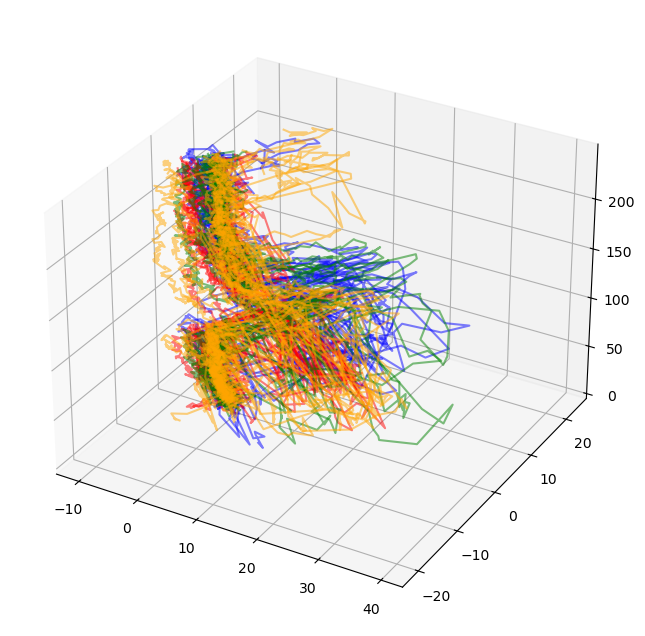

In [28]:
# Now flatten to (trialxtime, cell)
trial_cell_array = trial_array.reshape(trial_array.shape[0] * trial_array.shape[1], trial_array.shape[2])
# Perform PCA on the trial-cell array
pca_trial = PCA(n_components=2)
pca_trial_result = pca_trial.fit_transform(trial_cell_array)
# Reshape the trial-cell array to (trial, time, pcs)
pca_trial_result = pca_trial_result.reshape(-1, 250, pca_trial_result.shape[1])
# Plot the PCA result for trial-cell array
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
# Color mapping based on which stim condition
color_mapping = 15*['blue'] + 15*['red'] + 11*['green'] + 16*['orange']
for trial in range(pca_trial_result.shape[0]):
    ax.plot(pca_trial_result[trial, :, 0], pca_trial_result[trial, :, 1], zs=np.arange(250), alpha=0.5, color = color_mapping[trial])

Text(0.5, 0.92, 'PCA of stimulus-aligned response (Trial averaged)')

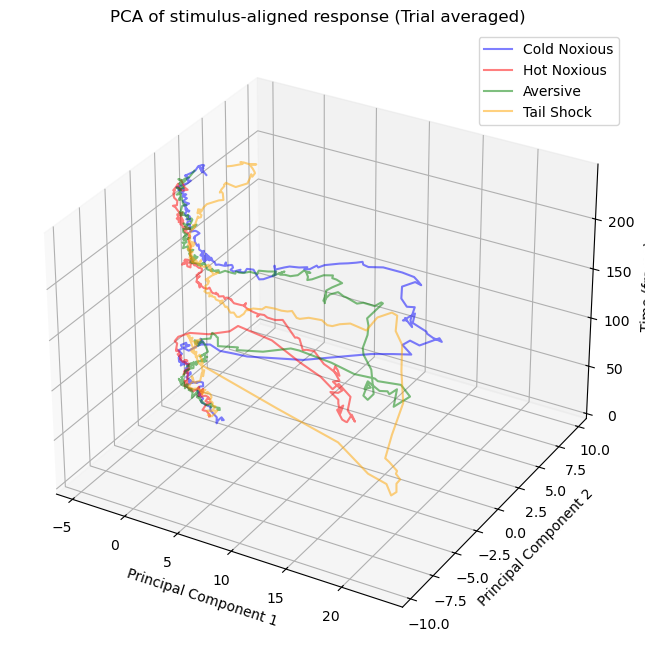

In [33]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.plot(pca_trial_result[:15, :, 0].mean(axis=0), pca_trial_result[:15, :, 1].mean(axis=0), zs=np.arange(250), alpha=0.5, color = 'blue')
ax.plot(pca_trial_result[15:30, :, 0].mean(axis=0), pca_trial_result[15:30, :, 1].mean(axis=0), zs=np.arange(250), alpha=0.5, color = 'red')
ax.plot(pca_trial_result[30:41, :, 0].mean(axis=0), pca_trial_result[30:41, :, 1].mean(axis=0), zs=np.arange(250), alpha=0.5, color = 'green')
ax.plot(pca_trial_result[41:57, :, 0].mean(axis=0), pca_trial_result[41:57, :, 1].mean(axis=0), zs=np.arange(250), alpha=0.5, color = 'orange')
plt.legend(['Cold Noxious', 'Hot Noxious', 'Aversive', 'Tail Shock'])
ax.set(xlabel='Principal Component 1', ylabel='Principal Component 2', zlabel='Time (frame)')
plt.title('PCA of stimulus-aligned response (Trial averaged)')

### SVM of trial

In [7]:
# Now do (trial, time*cell)

trial_pop_array = trial_array.reshape(trial_array.shape[0], -1)


In [21]:
def svm_simulations(trial_array, stim_labels, task, simulation_trials=1000, neuron_subset=1):
    accuracies = []
    tasks = []
    shuffleds = []
    for simulation_idx in range(simulation_trials):
        if neuron_subset < 1:
            # Randomly select a subset of neurons
            num_neurons = int(trial_array.shape[-1] * neuron_subset)
            selected_neurons = np.random.choice(trial_array.shape[-1], num_neurons, replace=False)
            trial_array_subset = trial_array[:, :, selected_neurons]
            trial_pop_array_subset = trial_array_subset.reshape(trial_array_subset.shape[0], -1)
        else:
            trial_pop_array_subset =  trial_array.reshape(trial_array.shape[0], -1)
        # Split the data into training and testing sets
        X_train, X_test, y_train, y_test = train_test_split(trial_pop_array_subset, stim_labels, test_size=0.2, random_state=42)

        # Create a LinearSVC model
        svm = LinearSVC(random_state=42)
        svm.fit(X_train, y_train)
        accuracies.append(svm.score(X_test, y_test))
        tasks.append(task)
        shuffleds.append(False)
        
        # Shuffle the labels and repeat
        shuffled_labels = np.random.permutation(stim_labels)
        X_train, X_test, y_train, y_test = train_test_split(trial_pop_array_subset, shuffled_labels, test_size=0.2, random_state=42)
        svm.fit(X_train, y_train)
        accuracies.append(svm.score(X_test, y_test))
        tasks.append(task)
        shuffleds.append(True)
    return accuracies, tasks, shuffleds

In [9]:
# Multiclass
accuracies, tasks, shuffleds = svm_simulations(trial_pop_array, stim_labels, 'multiclass')
df = pd.DataFrame({'accuracy': accuracies, 'task': tasks, 'shuffled': shuffleds})
# Cold Noxious vs rest
cold_noxious_labels = [1 if label == 0 else 0 for label in stim_labels]
accuracies, tasks, shuffleds = svm_simulations(trial_pop_array, cold_noxious_labels, 'Cold Noxious vs Rest')
cold_noxious_df = pd.DataFrame({'accuracy': accuracies, 'task': tasks, 'shuffled': shuffleds})
# Hot Noxious vs rest
hot_noxious_labels = [1 if label == 1 else 0 for label in stim_labels]
accuracies, tasks, shuffleds = svm_simulations(trial_pop_array, hot_noxious_labels, 'Hot Noxious vs Rest')
hot_noxious_df = pd.DataFrame({'accuracy': accuracies, 'task': tasks, 'shuffled': shuffleds})
# Aversive vs rest
aversive_labels = [1 if label == 2 else 0 for label in stim_labels]
accuracies, tasks, shuffleds = svm_simulations(trial_pop_array, aversive_labels, 'Aversive vs Rest')
aversive_df = pd.DataFrame({'accuracy': accuracies, 'task': tasks, 'shuffled': shuffleds})
# Tail shock vs rest
tail_shock_labels = [1 if label == 3 else 0 for label in stim_labels]
accuracies, tasks, shuffleds = svm_simulations(trial_pop_array, tail_shock_labels, 'Tail Shock vs Rest')
tail_shock_df = pd.DataFrame({'accuracy': accuracies, 'task': tasks, 'shuffled': shuffleds})
# Combine all dataframes
df = pd.concat([df, cold_noxious_df, hot_noxious_df, aversive_df, tail_shock_df], ignore_index=True)


([0, 1, 2, 3, 4],
 [Text(0, 0, 'multiclass'),
  Text(1, 0, 'Cold Noxious vs Rest'),
  Text(2, 0, 'Hot Noxious vs Rest'),
  Text(3, 0, 'Aversive vs Rest'),
  Text(4, 0, 'Tail Shock vs Rest')])

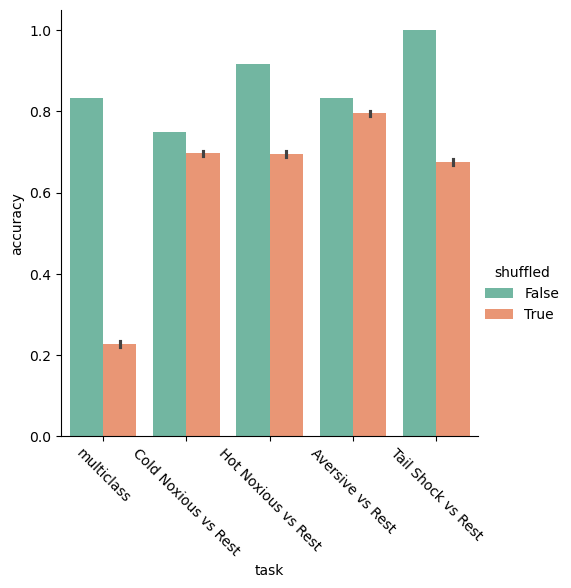

In [14]:
sns.catplot(x='task', y='accuracy', hue='shuffled', data=df, kind='bar', palette='Set2')
# make x-axis labels more readable
plt.xticks(rotation=-45)

In [22]:
num_neurons_dfs = []
for neuron_subset in [0.1, 0.2, 0.5, 1]:
    accuracies, tasks, shuffleds = svm_simulations(trial_array, stim_labels, 'multiclass', neuron_subset=neuron_subset)
    df_subset = pd.DataFrame({'accuracy': accuracies, 'task': tasks, 'shuffled': shuffleds, 'neuron_subset': neuron_subset})
    num_neurons_dfs.append(df_subset)
num_neurons_df = pd.concat(num_neurons_dfs, ignore_index=True)

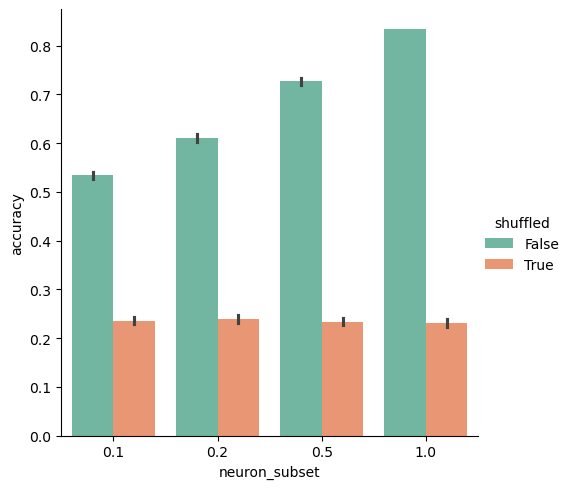

In [23]:
sns.catplot(x='neuron_subset', y='accuracy', hue='shuffled',  data=num_neurons_df, kind='bar', palette='Set2')